# Approximating functions with deep ReLU networks
*Practical session during the [DEADALUS Introductory Intensive Course](https://daedalus-berlin.github.io/events.html), December, 2018.*
The content is mostly based on [D. Yarotsky, 2017](https://www.sciencedirect.com/science/article/pii/S0893608017301545).

## Part IV: Approximating functions with Tensorflow networks (solution)

Let us now realize our approximation theoretic thoughts in Tensorflow 

In [1]:
import numpy as np
import tensorflow as tf
import target_functions as tfunc
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

### General Setup

Lets start with defining some constants, settings, configurations.

In [2]:
# general settings
DOMAIN = [0.0, 1.0, 0.0, 1.0]   # unit square [0, 1] x [0, 1]
RESOLUTION = 200                # grid resolution for testing the trained model

# network settings
WIDTH = 20              # number of neurons per hidden layer
DEPTH = 6               # total number of layers (number of hidden layers is DEPTH-2)
ACTIVATION = tf.nn.relu # hidden layer activation function

# training settings
INIT_L_RATE  = 5e-3
FINAL_L_RATE = 1e-4
NUM_ITER     = 2000
BATCH_SIZE   = 2048

# setup target function
REGULARITY = [2, 3]
def target_func(x, y):
    smooth_part = 2*tfunc.bernstein2d(x, y, [2, 3], [3, 4])
    nonsmooth_part = 2*np.math.factorial(REGULARITY[0]) \
        * np.math.factorial(REGULARITY[1]) \
        * tfunc.signpoly2d(x-0.4, y-0.6, REGULARITY)
    return smooth_part + nonsmooth_part

In [ ]:
? tf.concat

### Define the model

Next we build the neural network computational graph.

In [3]:
# define input and output layer
input = tf.placeholder(tf.float32, [None, 2])
target = tf.placeholder(tf.float32, [None, 1])

# define hidden layers with forward skip connections
hidden = (DEPTH-1)*[None]
hidden[0] = input
for l in range(DEPTH-2):
    if l>0:
        hidden[l+1] = tf.layers.dense(
            tf.concat(hidden[:l+1], axis=1),
            WIDTH,
            activation=ACTIVATION
        )
    else:
        hidden[l+1] = tf.layers.dense(
            hidden[l],
            WIDTH,
            activation=ACTIVATION
        )

# final layer without ReLU activation
prediction = tf.layers.dense(tf.concat(hidden, axis=1), 1, activation=None)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


### Define the training procedure

Next we define the loss, optimizer, descent steps, and other variable we want to keep track of during training.

In [4]:
# use decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)

# L2 loss function
# (we want L_inf error, but use smooth L2 error for optimization instead)
loss = 1/2*tf.reduce_mean(tf.square(prediction-target))

# Linf error (we can however still monitor this)
error = tf.reduce_max(tf.abs(prediction-target))

# use gradient descent during optimization
step = tf.train.GradientDescentOptimizer(learning_rate).minimize(
    loss,
    global_step=global_step
)

### Bookkeeping

Let us take a short break and print some information to get an overview of the constructed network.

In [5]:
print('\n----------------------------------------------------') 
print(' RUNNING EXPERIMENT WITH THE FOLLOWING PARAMETERS: ')
print('----------------------------------------------------\n')
print('depth:\t\t\t{}'.format(DEPTH))
print('width:\t\t\t{}'.format(WIDTH))
print('number of neurons:\t{}'.format(2+(DEPTH-2)*WIDTH+1))
print('number of connections:\t{}'.format(2+(DEPTH-2)*WIDTH*3+WIDTH*WIDTH*(DEPTH-3)*(DEPTH-2)//2))
print('activation:\t\t{}'.format(ACTIVATION.__name__))
print('learning rate:\t\t{} to {}'.format(INIT_L_RATE, FINAL_L_RATE))
print('iterations:\t\t{}'.format(NUM_ITER))
print('batch size:\t\t{}'.format(BATCH_SIZE))
print('regularity:\t\t{}'.format(REGULARITY))
print('\n\n')


----------------------------------------------------
 RUNNING EXPERIMENT WITH THE FOLLOWING PARAMETERS: 
----------------------------------------------------

depth:			6
width:			20
number of neurons:	83
number of connections:	2642
activation:		relu
learning rate:		0.005 to 0.0001
iterations:		2000
batch size:		2048
regularity:		[2, 3]





### Run the training

Let us now start the session and run the training steps.

In [6]:
# start Tensorflow session and initialize all network variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# run gradient descent steps
print('\nStarted training...')
print('{:8s}\t{:8s}\t{:8s}'.format('iter', 'l2-loss', 'linf-err'))
print('{:8s}\t{:8s}\t{:8s}'.format(*(3*[8*'-'])))
for iter in range(NUM_ITER):
    # generate random batch of inputs and corresponding target values
    input_batch = [DOMAIN[1]-DOMAIN[0], DOMAIN[3]-DOMAIN[2]] \
                  * np.random.rand(BATCH_SIZE, 2) \
                  + [DOMAIN[0], DOMAIN[2]]
    target_batch = np.reshape(
        target_func(input_batch[:, 0], input_batch[:, 1]),
        [-1, 1]
    )

    # take gradient descent step and compute loss & error
    loss_val, error_val, _ = session.run(
        [loss, error, step],
        feed_dict={input: input_batch, target: target_batch}
    )
    if iter % 100 == 0:
        print('{:8d}\t{:1.2e}\t{:1.2e}'.format(iter, loss_val, error_val))
print('...finished training.\n')


Started training...
iter    	l2-loss 	linf-err
--------	--------	--------
       0	1.33e-02	3.95e-01
     100	3.64e-03	2.31e-01
     200	3.59e-03	2.17e-01
     300	3.53e-03	2.13e-01
     400	3.38e-03	2.10e-01
     500	3.44e-03	2.08e-01
     600	3.24e-03	2.07e-01
     700	3.21e-03	2.06e-01
     800	3.28e-03	2.05e-01
     900	3.51e-03	2.05e-01
    1000	3.17e-03	2.04e-01
    1100	3.15e-03	2.04e-01
    1200	3.24e-03	2.03e-01
    1300	2.99e-03	2.03e-01
    1400	3.16e-03	2.03e-01
    1500	3.32e-03	2.03e-01
    1600	3.13e-03	2.02e-01
    1700	3.15e-03	2.03e-01
    1800	3.03e-03	2.02e-01
    1900	3.14e-03	2.02e-01
...finished training.



### Evaluate the trainined network

After finishing the training phase it is time to check what our network has learned.

Error of predictions after training, evaluated on 200x200 grid:
l2:	3.1834e-03
l2inf:	2.0299e-01


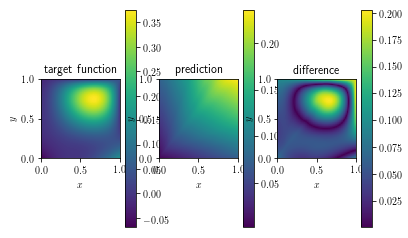

In [7]:
# generate full sample grid of input domain
xrange = np.linspace(DOMAIN[0], DOMAIN[1], num=RESOLUTION)
yrange = np.linspace(DOMAIN[2], DOMAIN[3], num=RESOLUTION)
xgrid, ygrid = np.meshgrid(xrange, yrange)
input_test_batch = np.stack([xgrid.flatten(), ygrid.flatten()], axis=1)

# get model predictions
prediction_test_batch = np.reshape(
    session.run(
        prediction,
        feed_dict={input: input_test_batch}
    ),
    xgrid.shape
)

# get actual target values and compare with predictions
target_test_batch = target_func(xgrid, ygrid)
l2_err = 1/2*np.mean(np.square(prediction_test_batch-target_test_batch))
linf_err = np.max(np.abs(prediction_test_batch-target_test_batch))
print(
    'Error of predictions after training, evaluated on {}x{} grid:'
    .format(RESOLUTION, RESOLUTION)
)
print('l2:\t{:1.4e}'.format(l2_err))
print('l2inf:\t{:1.4e}'.format(linf_err))

# plot actual target, prediction, and comparison
plt.subplot(1,3,1)
plt.imshow(target_test_batch, extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('target function')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(prediction_test_batch, extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('prediction')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(target_test_batch-prediction_test_batch), extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('difference')
plt.colorbar()

plt.show()

### Cleanup

Once we are done we can close the session, which will free memory of all our tensors. This is optional, as the session is automatically closed once we close Python.

In [ ]:
session.close()